# 5. Capstone Project: Machine Learning Models I

***

![headerall](./images/headers/header_all.jpg)

##  Goals

### Project:
In this work, we will first analyze where and when traffic congestion is highest and lowest in New York State. We will then build different machine learning models capable of predicting cab travel times in and around New York City using only variables that can be easily obtained from a smartphone app or a website. We will then compare their performance and explore the possibility of using additional variables such as weather forecasts and holidays to improve the predictive performance of the models.

### Section:
In this section, we will use the knowledge gained during the exploratory data analysis to perform the final feature transformation. Next, we will create and compare the performance of three machine learning models based on linear regression, support vector machine, and a gradient enhanced decision tree. Hyperparameters will be optimized for each model to achieve the best possible performance.

## Data
### External Datasets:
- Weather Forecast: The 2018 NYC weather forecast was collected from the [National Weather Service Forecast Office](https://w2.weather.gov/climate/index.php?wfo=okx) website. Daily measurements were taken from January to December 2018 in Central Park. These measures are given in imperial units and include daily minimum and maximum temperatures, precipitations, snowfall, and snow depth.

- Holidays: The 2018 NYC holidays list was collected from the [Office Holiday](https://www.officeholidays.com/countries/usa/new-york/2021) website. The dataset contains the name, date, and type of holidays for New York.

- Taxi Zones: The NYC Taxi Zones dataset was collected from the [NYC Open Data](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) website. It contains the pickup and drop-off zones (Location IDs) for the Yellow, Green, and FHV Trip Records. The taxi zones are based on the NYC Department of City Planning’s Neighborhood.

### Primary Datasets:

- Taxi Trips: The 2018 NYC Taxi Trip dataset was collected from the [Google Big Query](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips?project=jovial-monument-300209&folder=&organizationId=) platform. The dataset contains more than 100'000'000 Yellow Taxi Trip records for 2018 and contains an extensive amount of variables including the pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

***
## Table of Content:
    1. Data Preparation
        1.1 External Datasets
            1.1.1 Weather Forecast Dataset
            1.1.2 Holidays Dataset
            1.1.3 Taxi Zones Dataset
        1.2 Primary Dataset
            1.2.1 Taxi Trips Dataset
            1.2.2 Taxi Trips Subset
    2. Exploratory Data Analysis
        2.1 Primary Dataset
            2.1.1 Temporal Analysis
            2.1.2 Spatio-Temporal Analysis
        2.2 External Datasets
            2.2.1 Temporal Analysis of Weather Data
            2.2.2 Temporal Analysis of Holidays Data
        2.3 Combined Dataset
            2.3.1 Overall Features Correlation
    3. Machine Learning Models
        3.1 Data Preparation
        3.2 Baselines
        3.2 Model Training
            3.2.1 Linear Regression
            3.2.2 Support Vector Machine
            3.2.3 Gradient Boosted Decision Tree

***
## Python Libraries and Magic commands Import

In [1]:
# Import python core libraries
import itertools

# Import data processing libraris gpd
import pandas as pd
import geopandas as gpd
import numpy as np

# Import Visualization librairies
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py
import scipy.stats as stats

# Import machine learning libraries
from sklearn.base import clone
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE 

In [2]:
# Set up magic commands
%matplotlib inline
%config Completer.use_jedi = False

***

## Data Import

In [3]:
# Import the train dataset
train_df = pd.read_pickle(r'data/processed/train.pickle')

# Get the independant variables from the train dataset
X_tr = train_df.drop("trip_duration", axis=1)

# Get the dependant variable from the train dataset
y_tr = train_df["trip_duration"]

print('X_tr:', X_tr.shape)
print('y_tr:', y_tr.shape, y_tr.dtype)

X_tr: (824654, 33)
y_tr: (824654,) float64


In [4]:
# Import the test dataset
test_df = pd.read_pickle(r'data/processed/test.pickle')

# Get the independant variables from the test dataset
X_te = test_df.drop("trip_duration", axis=1)

# Get the dependant variable from the test dataset
y_te = test_df["trip_duration"]

print('X_te:', X_te.shape)
print('y_te:', y_te.shape, y_te.dtype)

X_te: (206156, 33)
y_te: (206156,) float64


***
## Functions Import

In [5]:
# Define a function that transform column headers to titles
def to_title(data, sep='_'):
    return [s.replace(sep, ' ').title() for s in data]

In [6]:
# Define a function that display scatter plots of selected numerical columns
def plot_scatter(data, columns, colnames, variable, ncols=1, nrows=1, color="C0"):

    varname = variable.replace("_", " ").title()

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols * 5, nrows * 5)
    )

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        sns.scatterplot(x=col, y=variable, data=data, ax=ax, s=10, color=color)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_ylim(0)
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel(varname, fontsize=14)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [7]:
# Define a function that display scatter plots of selected numerical columns
def plot_histplot(data, columns, colnames, ncols=1, nrows=1, color="C0"):

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols * 5, nrows * 5)
    )

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        sns.histplot(
            x=col, bins=20, data=data, ax=ax, color=color, edgecolor="white", alpha=0.7
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel("Count", fontsize=14)
        ax.set_title(colname, fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [8]:
def diagnostic_plots(data, variable, transform=None):

    if transform:
        data = data.copy()
        data[variable] = data[variable].apply(transform)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    data[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(data[variable], dist="norm", plot=plt)

    plt.show()

In [9]:
def transform_opt(data, transformations, showBest=True):

    output = pd.DataFrame({"None": data.skew()})

    for tr in transformations:
        data_copy = data.copy()
        output[tr.__name__] = data_copy.apply(tr).skew()

    if filter:
        return output.loc[np.abs(output["None"]) > 1]

    return output

***
# 3. Machine Learning Models
## 3.1 Machine Learning Models: Data Preparation

## Goals:

## Code:


In [10]:
# Get id column names from the train dataset
id_cols = [c for c in train_df.columns if "id" in c]

# Remove ID features in the train dataset
train_df.drop(id_cols, axis=1, inplace=True)

# Remove ID features in the test dataset
test_df.drop(id_cols, axis=1, inplace=True)

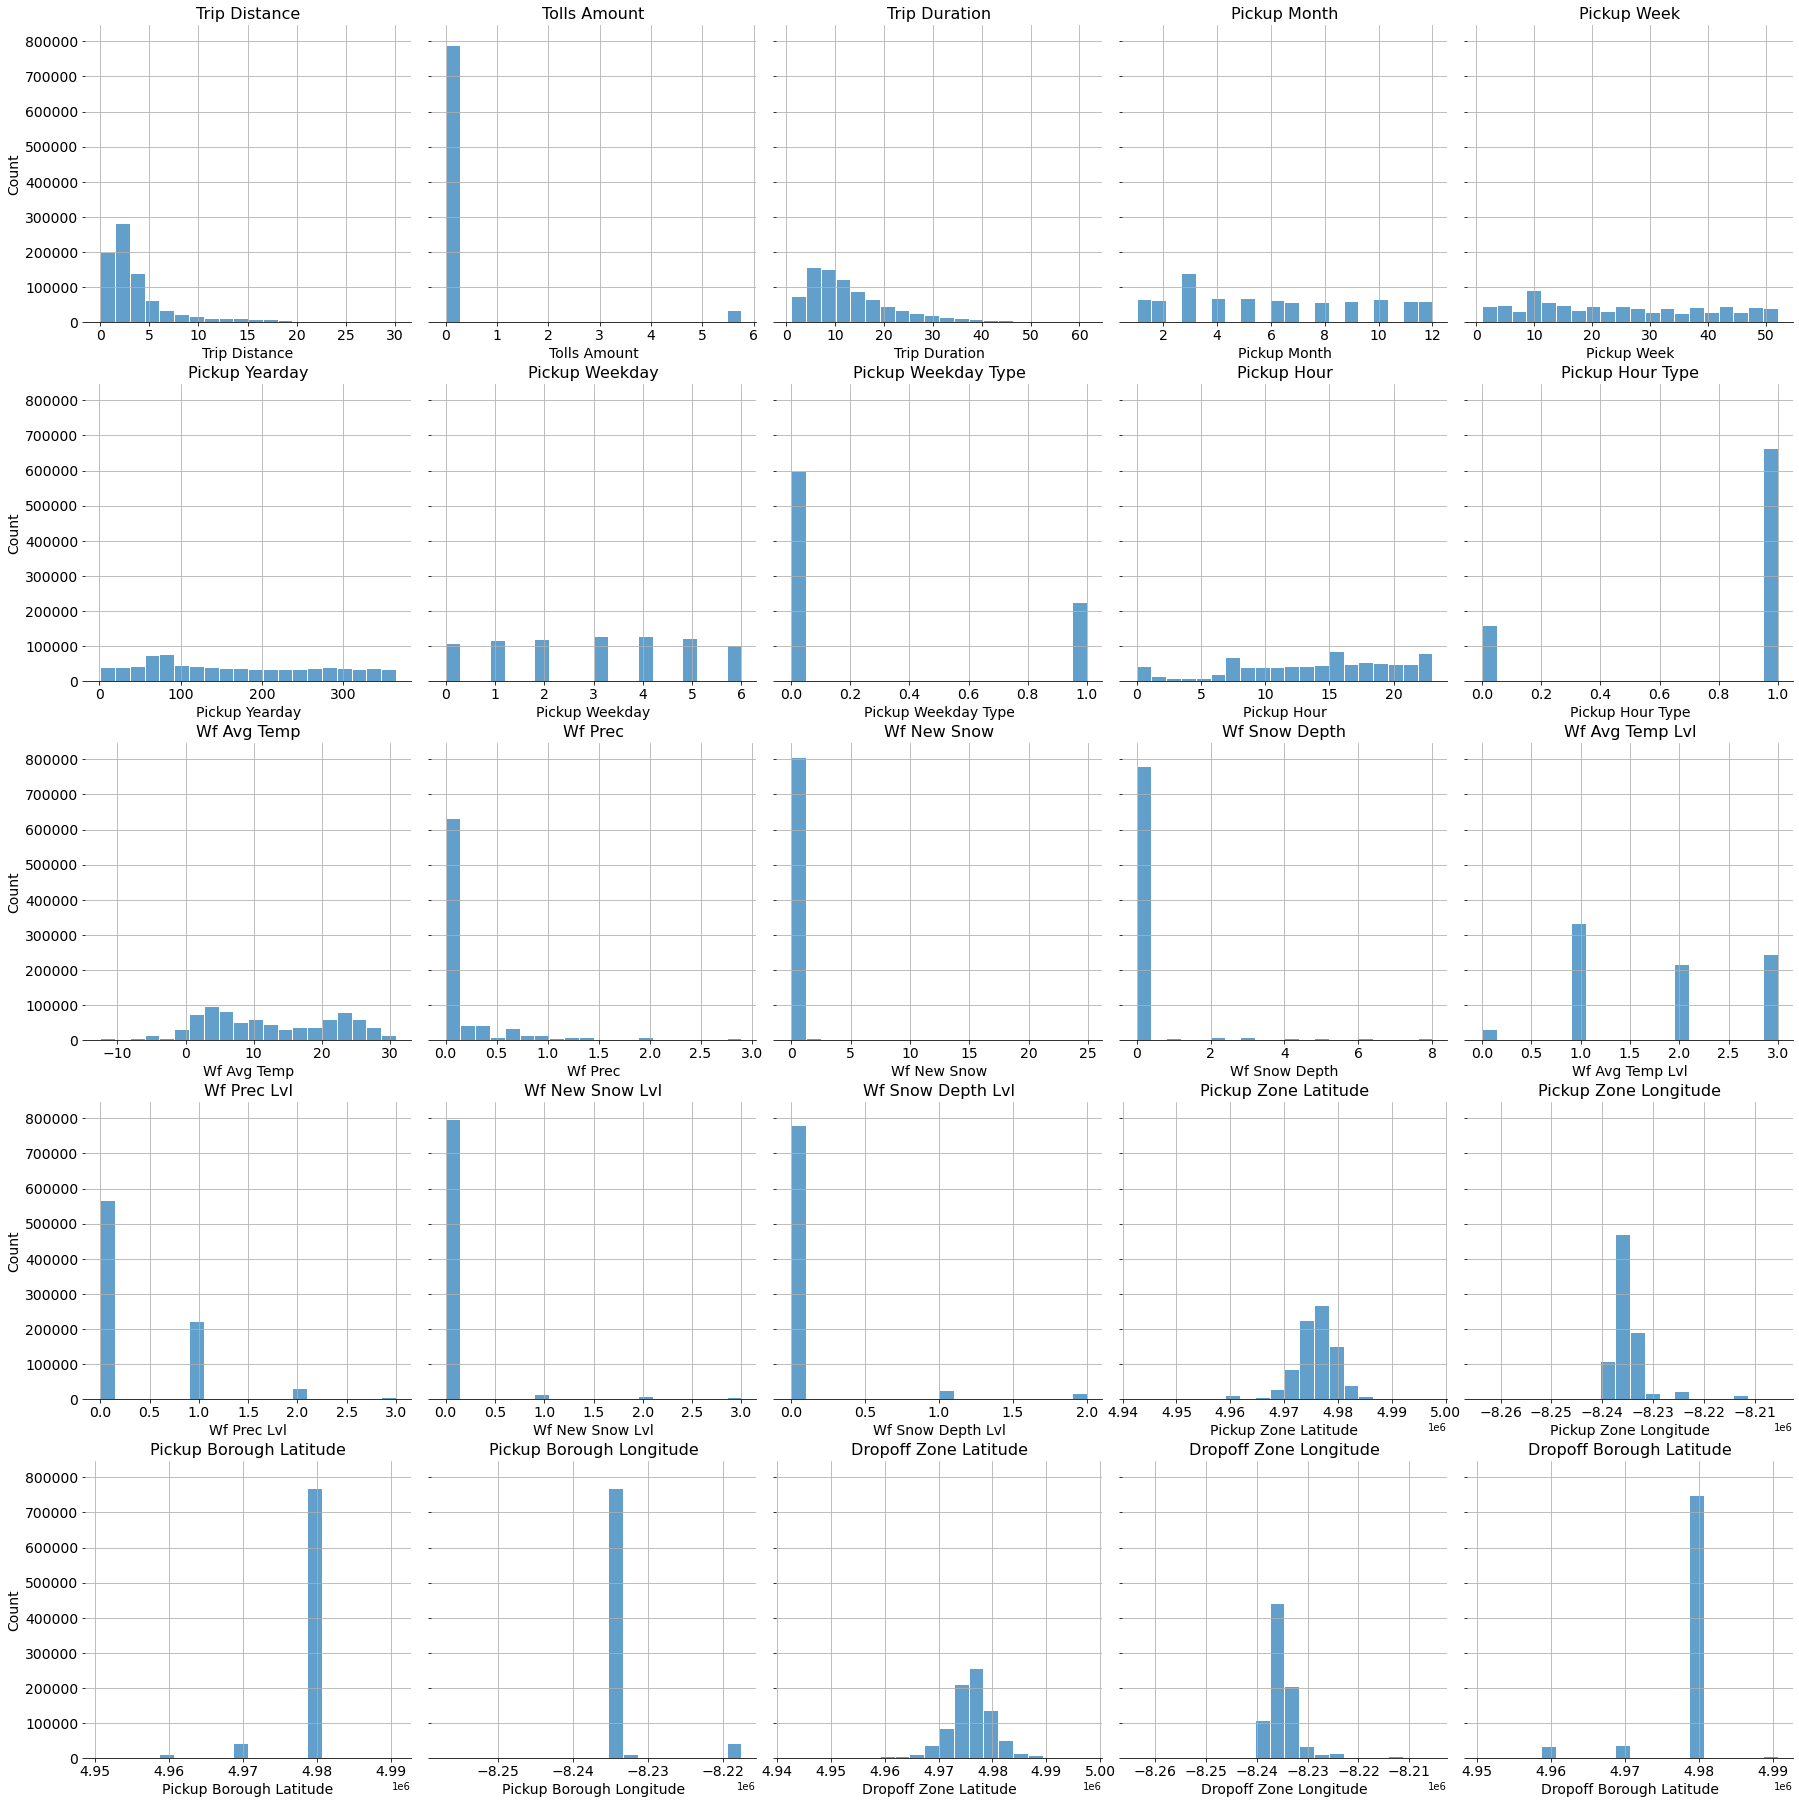

In [11]:
# Get the name of numerical columns
train_num_cols = train_df.columns

# Display scatterplot of numerical columns
plot_histplot(
    train_df,
    train_num_cols,
    to_title(train_num_cols),
    ncols=5,
    nrows=5,
)

In [12]:
#
transformations = [np.log10, np.log1p, np.square, np.sqrt, np.exp]

#
transform_opt(train_df, transformations, showBest=False)

/Users/thomasstricker/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/nanops.py:1178: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted ** 2


,None,log10,log1p,square,sqrt,exp
trip_distance,2.776230,0.389387,0.960956,4.902220,1.619644,18.512662
tolls_amount,4.638982,NaN,4.626269,4.652049,4.626119,4.658063
trip_duration,1.603420,-0.195451,0.001339,3.544290,0.711595,45.089997
pickup_weekday_type,1.020380,NaN,1.020380,1.020380,1.020380,1.020380
pickup_hour_type,-1.553683,NaN,-1.553683,-1.553683,-1.553683,-1.553683
wf_prec,3.425993,NaN,2.430261,7.274151,1.728736,8.411640
wf_new_snow,9.223834,NaN,7.355789,12.044836,7.543670,29.562308
wf_snow_depth,5.638233,NaN,4.611249,7.718923,4.590881,12.250835
wf_prec_lvl,1.592009,NaN,1.065455,4.542668,0.943447,5.781420
wf_new_snow_lvl,6.912921,NaN,6.039903,9.178275,5.789853,10.113432


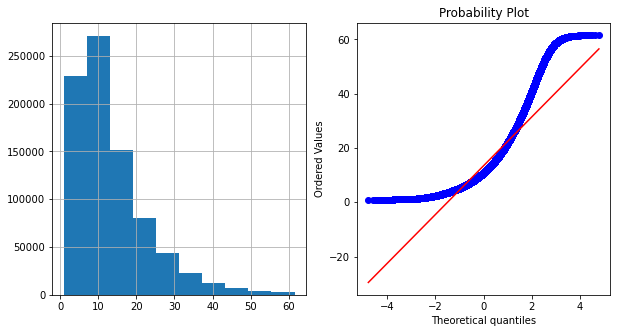

In [13]:
diagnostic_plots(train_df, "trip_duration")

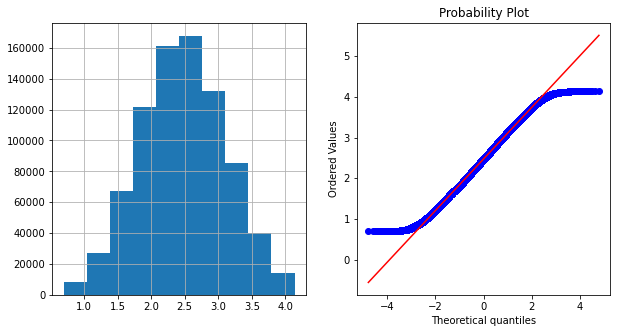

In [14]:
diagnostic_plots(train_df, "trip_duration", transform=np.log1p)

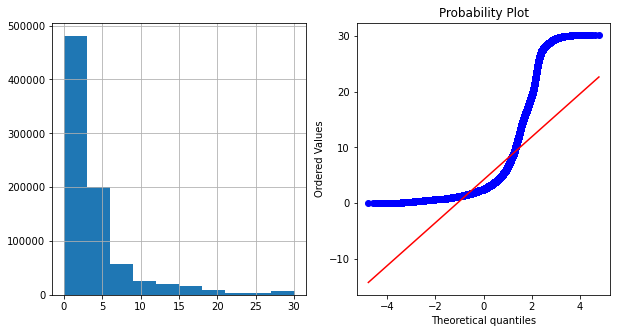

In [15]:
diagnostic_plots(train_df, "trip_distance")

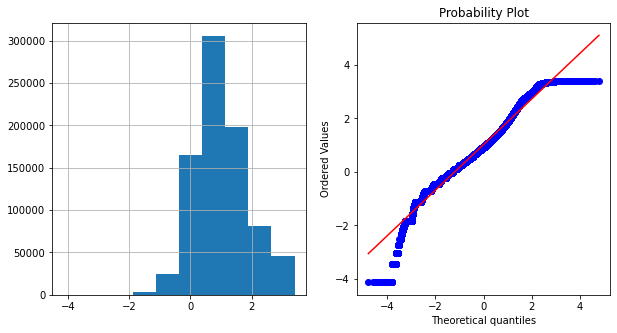

In [16]:
diagnostic_plots(train_df, "trip_distance", transform=np.log)

### Data Preparation: Principal Compenent Analysis

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [21]:
# Create Standard scaler
scaler = StandardScaler()

# Rescale the train data
X_tr_rescaled = scaler.fit_transform(X_tr)

# Create PCA transformer
pca = PCA(n_components = None)

# Apply PCA to the rescalled train data
pca.fit(X_tr_rescaled, y=None)

# Get the proportion of variance explained
pve = pca.explained_variance_ratio_

print(f'Train dataset shape:{X_tr.shape}, minimum components: {min(X_tr.shape)}')

Train dataset shape:(824654, 33), minimum components: 33


In [22]:
# Get the cumulative sum
pve_cumsum = np.cumsum(pve)

# Round the cumulative sum
pve_cumsum_rounded = np.round((pve_cumsum*100), 0).astype('int32')

# Create a list that collects the index of the 10% variance steps
variance_idx = []

# # Display the cumulative sum of variance explained
for f in pve_cumsum_rounded:
    components = np.where(pve_cumsum_rounded == f)[0][0] + 1
    variance_idx.append(components)
    
    print(f'Variance explained: {f}%, Number of components: {components}')

Variance explained: 17%, Number of components: 1
Variance explained: 28%, Number of components: 2
Variance explained: 36%, Number of components: 3
Variance explained: 43%, Number of components: 4
Variance explained: 49%, Number of components: 5
Variance explained: 55%, Number of components: 6
Variance explained: 60%, Number of components: 7
Variance explained: 66%, Number of components: 8
Variance explained: 70%, Number of components: 9
Variance explained: 74%, Number of components: 10
Variance explained: 77%, Number of components: 11
Variance explained: 80%, Number of components: 12
Variance explained: 84%, Number of components: 13
Variance explained: 86%, Number of components: 14
Variance explained: 89%, Number of components: 15
Variance explained: 92%, Number of components: 16
Variance explained: 93%, Number of components: 17
Variance explained: 95%, Number of components: 18
Variance explained: 96%, Number of components: 19
Variance explained: 97%, Number of components: 20
Variance 

In [ ]:
def variance_plot(data):
    # Display a plot of the evolution of the variance vs number of PCA components
fig, ax = plt.subplots(figsize=(10,5))

ax.step(
    np.arange(1, len(pve) + 1),
    pve_cumsum,
    label='cumulative'
)

# Add vertical red lines to show 10% variance steps
for idx in variance_idx:
    ax.vlines(idx, ymin=0, ymax=1, color='red', alpha=0.5, linewidth=1.25)

# Add labels and a legend to the plot
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.legend()
plt.show()

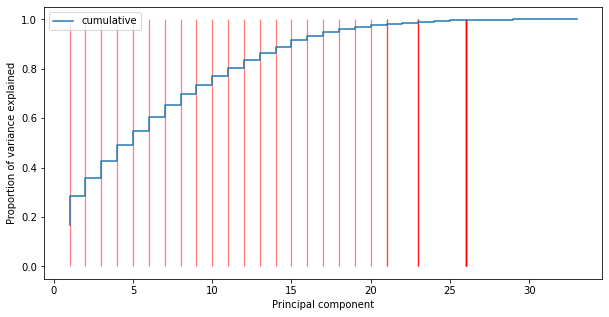

In [23]:
# Display a plot of the evolution of the variance vs number of PCA components
fig, ax = plt.subplots(figsize=(10,5))

ax.step(
    np.arange(1, len(pve) + 1),
    pve_cumsum,
    label='cumulative'
)

# Add vertical red lines to show 10% variance steps
for idx in variance_idx:
    ax.vlines(idx, ymin=0, ymax=1, color='red', alpha=0.5, linewidth=1.25)

# Add labels and a legend to the plot
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.legend()
plt.show()

In [ ]:
# Apply preprocessing to the train dataset
X_tr_p1 = preprocess(X_tr, categorical_cols, continuous_cols, ["trip_distance"])

# Apply preprocessing to the train dataset
X_te_p1 = preprocess(X_te, categorical_cols, continuous_cols, ["trip_distance"])

print("X_tr:", X_tr_p.shape)
print("X_te:", X_te_p.shape)

## 3.1 Machine Learning Models: Baselines


## Goals:

## Code:

In [ ]:
# Compute the MAE of the median baseline
mae_median_baseline = MAE(y_te, np.full(len(y_te), np.median(y_tr)))

print("The MAE of the median baseline is: {:.0f}".format(mae_median_baseline))

In [ ]:
# Compute the MAE of the median baseline
mse_mean_baseline = MSE(y_te, np.full(len(y_te), np.mean(y_tr)))

print("The MSE of the mean baseline is: {:.0f}".format(mse_mean_baseline))

***

In [ ]:
# Create cross-validation object
param_grid_dt = {
    #"dt__splitter": ["best", "random"],
    "max_depth": np.linspace(0, 10)
    #"dt__min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"dt__min_weight_fraction_leaf": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    #"dt__max_features": ["auto", "log2", "sqrt", None],
    #"dt__max_leaf_nodes": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90],
}

# Create a GridSearch object to find optimum hyperparameters
grid_cv_dt = GridSearchCV(
    dt,
    param_grid_dt,
    cv=5,
    return_train_score=True,
    verbose=True,
    n_jobs=-1,
)

# Fit estimator to the combined train data
grid_cv_dt.fit(X_tr, y_tr)

# Collect results in a DataFrame
cv_results_svc = pd.DataFrame(grid_cv_dt.cv_results_)

# Display the scores and hyperparameters columns
cols_svc = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
]